## UNET CNN

In [35]:
from ReadData import *
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, Flatten, Reshape, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import KFold

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [3]:
def readData(path, getTargetName = False):
    # print(getTargetName)
    data = getEMData(path)
    target = []
    field = []
    freq = []
    if getTargetName:
        targetName = []
        upper_case = [char for char in path if char.isupper()]
        target_name = path[path.index(upper_case[0]):path.index(upper_case[1])]

    for i in range(0, len(data)):
        target.append(data[i].target)
        field.append(data[i].Esct.real)
        freq.append(data[i].freq)
        if getTargetName: targetName.append(target_name)

    field = np.array(field)
    target = np.array(target)
    freq = np.array(freq)
    if getTargetName: targetName = np.array(targetName)

    result = (field, target, freq)
    if getTargetName: result = (field, target, freq, targetName)
    return result

Load EMNIST data with fixed permittivity

In [4]:
fieldMNIST, targetMNIST, freqMNIST = readData(path = "./testing/", getTargetName=False)

fieldMNIST_transformed = np.reshape(fieldMNIST, (fieldMNIST.shape[0], fieldMNIST.shape[1], fieldMNIST.shape[2], 1))
targetMNIST_transformed = np.reshape(targetMNIST, (targetMNIST.shape[0], targetMNIST.shape[1], targetMNIST.shape[2], 1))

fieldMNIST_train_full, fieldMNIST_test, targetMNIST_train_full, targetMNIST_test= train_test_split(
    fieldMNIST_transformed, targetMNIST_transformed, test_size=0.20, random_state=123)

fieldMNIST_train, fieldMNIST_val, targetMNIST_train, targetMNIST_val= train_test_split(
    fieldMNIST_train_full, targetMNIST_train_full, test_size=0.20, random_state=123)

Read 690 samples


In [27]:
np.max(targetMNIST_train_full[0])

1.0

In [5]:
[fieldMNIST_train.shape,targetMNIST_train.shape]

[(441, 24, 24, 1), (441, 28, 28, 1)]

In [5]:
fieldMNIST_train_f_padded = np.pad(fieldMNIST_train_full, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_train_padded = np.pad(fieldMNIST_train, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_val_padded = np.pad(fieldMNIST_val, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')
fieldMNIST_test_padded = np.pad(fieldMNIST_test, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

In [6]:
[fieldMNIST_train_padded.shape,fieldMNIST_train_f_padded.shape]

[(441, 28, 28, 1), (552, 28, 28, 1)]

Load EMNIST data with added permittivity from Gaussian distribution

In [57]:
field_dif_perm, target_dif_perm, freq_dif_perm = readData(path = "./EMNIST_dif_perm/", getTargetName=False)

field_dif_perm_transformed = np.reshape(field_dif_perm, (field_dif_perm.shape[0], field_dif_perm.shape[1], field_dif_perm.shape[2], 1))
target_dif_perm_transformed = np.reshape(target_dif_perm, (target_dif_perm.shape[0], target_dif_perm.shape[1], target_dif_perm.shape[2], 1))

field_dif_perm_padded = np.pad(field_dif_perm_transformed, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

field_train_dif_perm, field_test_dif_perm, target_train_dif_perm, target_test_dif_perm= train_test_split(
    field_dif_perm_padded, field_dif_perm_padded, test_size=0.20, random_state=123)

# field_dif_perm_padded = np.pad(field_dif_perm_transformed, ((0, 0), (2, 2), (2, 2), (0, 0)), 'constant')

field_dif_perm_transformed.shape

Read 630 samples


(630, 24, 24, 1)

Define U-Net

In [25]:
def unet_padded(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(28, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(56, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(56, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(128, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(128, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(56, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(56, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(56, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(28, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(28, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(28, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    output = Conv2D(1, 1, activation='sigmoid')(conv4)


    model = Model(inputs=inputs, outputs=output)

    return model

Train on MNIST then test on shape (freq 1e9 and permitivity 2)

In [51]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
losses = []
val_losses = []
accuracy = []
val_accuracy = []
histories = []

acc_per_fold = []

   
Training for fold 1 ...
Epoch 1/80
56/56 [==============================] - 9s 82ms/step - loss: 0.8012 - accuracy: 0.5003 - val_loss: 0.6824 - val_accuracy: 0.6341 - lr: 2.5000e-05
Epoch 2/80
56/56 [==============================] - 4s 74ms/step - loss: 0.7030 - accuracy: 0.6307 - val_loss: 0.6538 - val_accuracy: 0.6695 - lr: 2.5000e-05
Epoch 3/80
56/56 [==============================] - 4s 79ms/step - loss: 0.6394 - accuracy: 0.6977 - val_loss: 0.6225 - val_accuracy: 0.6695 - lr: 2.5000e-05
Epoch 4/80
56/56 [==============================] - 6s 103ms/step - loss: 0.5933 - accuracy: 0.7404 - val_loss: 0.5915 - val_accuracy: 0.6717 - lr: 2.5000e-05
Epoch 5/80
56/56 [==============================] - 6s 113ms/step - loss: 0.5547 - accuracy: 0.7663 - val_loss: 0.5824 - val_accuracy: 0.6714 - lr: 2.5000e-05
Epoch 6/80
56/56 [==============================] - 5s 89ms/step - loss: 0.5183 - accuracy: 0.7891 - val_loss: 0.5702 - val_accuracy: 0.6741 - lr: 2.5000e-05
Epoch 7/80
56/56 [====

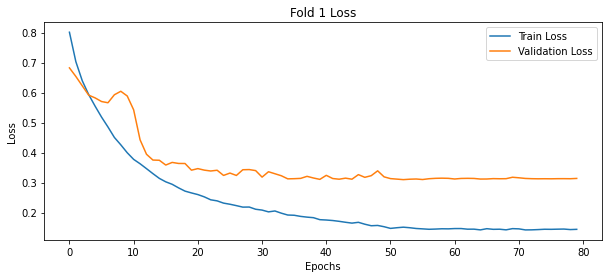

   
Training for fold 2 ...
Epoch 1/80
56/56 [==============================] - 8s 84ms/step - loss: 0.6132 - accuracy: 0.6708 - val_loss: 0.6449 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 2/80
56/56 [==============================] - 4s 73ms/step - loss: 0.5278 - accuracy: 0.7310 - val_loss: 0.6241 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 3/80
56/56 [==============================] - 4s 76ms/step - loss: 0.4780 - accuracy: 0.7680 - val_loss: 0.6607 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 4/80
56/56 [==============================] - 5s 81ms/step - loss: 0.4481 - accuracy: 0.7890 - val_loss: 0.7042 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 5/80
56/56 [==============================] - 5s 82ms/step - loss: 0.4223 - accuracy: 0.8081 - val_loss: 0.7395 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 6/80
56/56 [==============================] - 5s 88ms/step - loss: 0.3952 - accuracy: 0.8274 - val_loss: 0.7915 - val_accuracy: 0.6946 - lr: 2.5000e-05
Epoch 7/80
56/56 [======

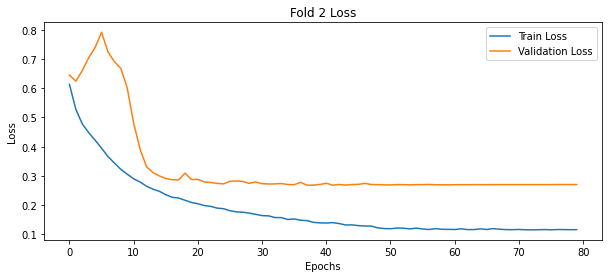

   
Training for fold 3 ...
Epoch 1/80
56/56 [==============================] - 8s 88ms/step - loss: 0.6254 - accuracy: 0.6711 - val_loss: 0.6393 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 2/80
56/56 [==============================] - 5s 87ms/step - loss: 0.5350 - accuracy: 0.7146 - val_loss: 0.6158 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 3/80
56/56 [==============================] - 5s 91ms/step - loss: 0.4835 - accuracy: 0.7526 - val_loss: 0.6438 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 4/80
56/56 [==============================] - 5s 87ms/step - loss: 0.4544 - accuracy: 0.7751 - val_loss: 0.7159 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 5/80
56/56 [==============================] - 5s 86ms/step - loss: 0.4311 - accuracy: 0.7928 - val_loss: 0.8145 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 6/80
56/56 [==============================] - 5s 87ms/step - loss: 0.4058 - accuracy: 0.8116 - val_loss: 0.9085 - val_accuracy: 0.6870 - lr: 2.5000e-05
Epoch 7/80
56/56 [======

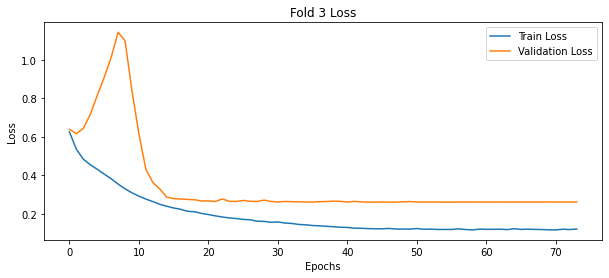

   
Training for fold 4 ...
Epoch 1/80
56/56 [==============================] - 7s 84ms/step - loss: 0.8095 - accuracy: 0.4535 - val_loss: 0.6948 - val_accuracy: 0.5033 - lr: 2.5000e-05
Epoch 2/80
56/56 [==============================] - 5s 92ms/step - loss: 0.7057 - accuracy: 0.6024 - val_loss: 0.6699 - val_accuracy: 0.6429 - lr: 2.5000e-05
Epoch 3/80
56/56 [==============================] - 5s 94ms/step - loss: 0.6448 - accuracy: 0.6811 - val_loss: 0.6426 - val_accuracy: 0.6813 - lr: 2.5000e-05
Epoch 4/80
56/56 [==============================] - 5s 92ms/step - loss: 0.5970 - accuracy: 0.7290 - val_loss: 0.6179 - val_accuracy: 0.6813 - lr: 2.5000e-05
Epoch 5/80
56/56 [==============================] - 5s 96ms/step - loss: 0.5576 - accuracy: 0.7602 - val_loss: 0.6073 - val_accuracy: 0.6814 - lr: 2.5000e-05
Epoch 6/80
56/56 [==============================] - 5s 93ms/step - loss: 0.5228 - accuracy: 0.7821 - val_loss: 0.6010 - val_accuracy: 0.6819 - lr: 2.5000e-05
Epoch 7/80
56/56 [======

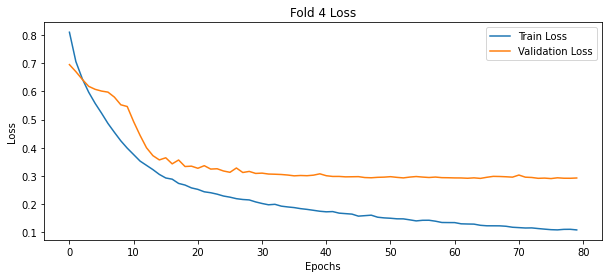

   
Training for fold 5 ...
Epoch 1/80
56/56 [==============================] - 10s 125ms/step - loss: 0.6683 - accuracy: 0.6206 - val_loss: 0.6746 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 2/80
56/56 [==============================] - 7s 119ms/step - loss: 0.5824 - accuracy: 0.7003 - val_loss: 0.6298 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 3/80
56/56 [==============================] - 6s 116ms/step - loss: 0.5225 - accuracy: 0.7460 - val_loss: 0.6329 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 4/80
56/56 [==============================] - 8s 136ms/step - loss: 0.4851 - accuracy: 0.7740 - val_loss: 0.6744 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 5/80
56/56 [==============================] - 6s 113ms/step - loss: 0.4560 - accuracy: 0.7940 - val_loss: 0.7017 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 6/80
56/56 [==============================] - 5s 96ms/step - loss: 0.4255 - accuracy: 0.8140 - val_loss: 0.7140 - val_accuracy: 0.6907 - lr: 2.5000e-05
Epoch 7/80
56/56 [

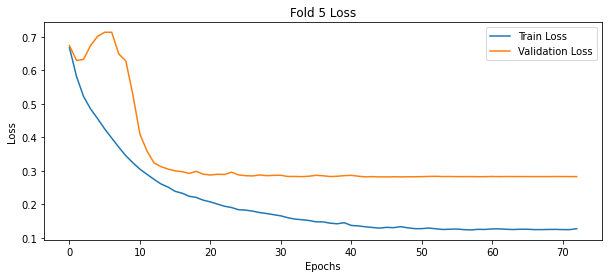

In [52]:
for train_index, val_index in kf.split(fieldMNIST_train_f_padded):
    print('   ')
    print(f'Training for fold {fold} ...')

    X_train, X_val = fieldMNIST_train_f_padded[train_index], fieldMNIST_train_f_padded[val_index]
    y_train, y_val = targetMNIST_train_full[train_index], targetMNIST_train_full[val_index]


    model1 = unet_padded(input_shape=X_train.shape[1:])

    model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2.5e-5), loss='binary_crossentropy', metrics='accuracy')
    early_stopping = EarlyStopping(monitor='loss', patience=15)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_delta=0.001, min_lr=1e-9)
    # checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
    history = model1.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=80, 
                        batch_size=8,
                        callbacks=[early_stopping,reduce_lr])
    histories.append(history.history)

        #Save model trained on each fold.
    model1.save('models/model_fold_'+str(fold)+'.h5')   

    # Evaluate the model - repor accuracy and capture it into a list for future reporting
    scores = model1.evaluate(fieldMNIST_test_padded, targetMNIST_test, verbose=0)
    acc_per_fold.append(scores[1] * 100)

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

    losses.append((history.history['loss']))
    val_losses.append((history.history['val_loss']))
    accuracy.append((history.history['accuracy']))
    val_accuracy.append((history.history['val_accuracy']))

    fold += 1

In [53]:
acc_per_fold

[87.74770498275757,
 88.30597400665283,
 88.19043636322021,
 88.44184279441833,
 88.48528265953064]

In [26]:
best_model = load_model('models/model_fold_5.h5')
pred_test = best_model.predict(fieldMNIST_test_padded)
pred_train = best_model.predict(fieldMNIST_train_padded)
pred_dif_perm = best_model.predict(field_test_dif_perm)

4/4 [==============================] - 0s 58ms/step


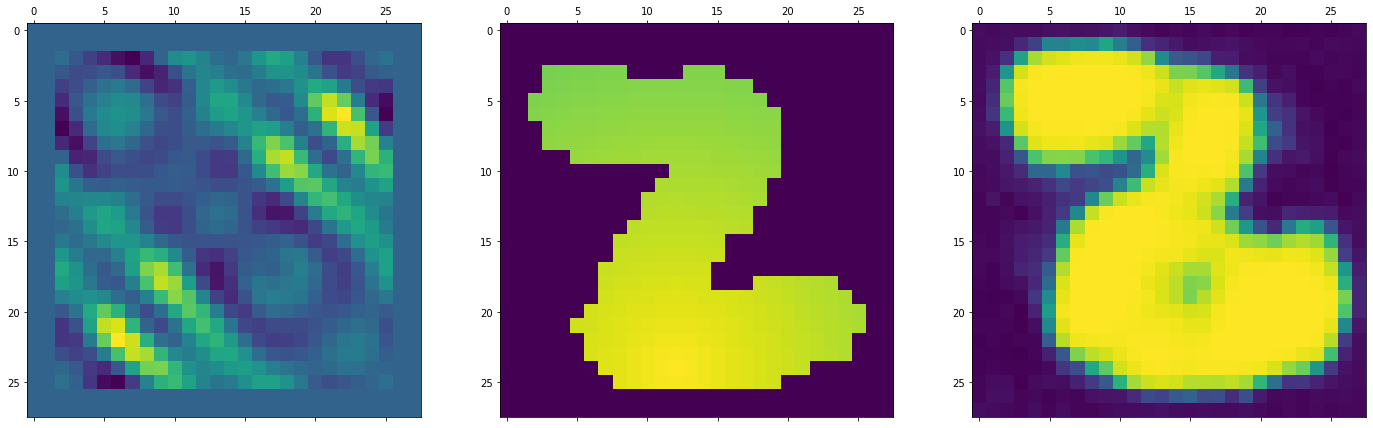

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(field_test_dif_perm[0])
axs[1].matshow(target_test_dif_perm[0])
axs[2].matshow(pred_dif_perm[0])

plt.show()

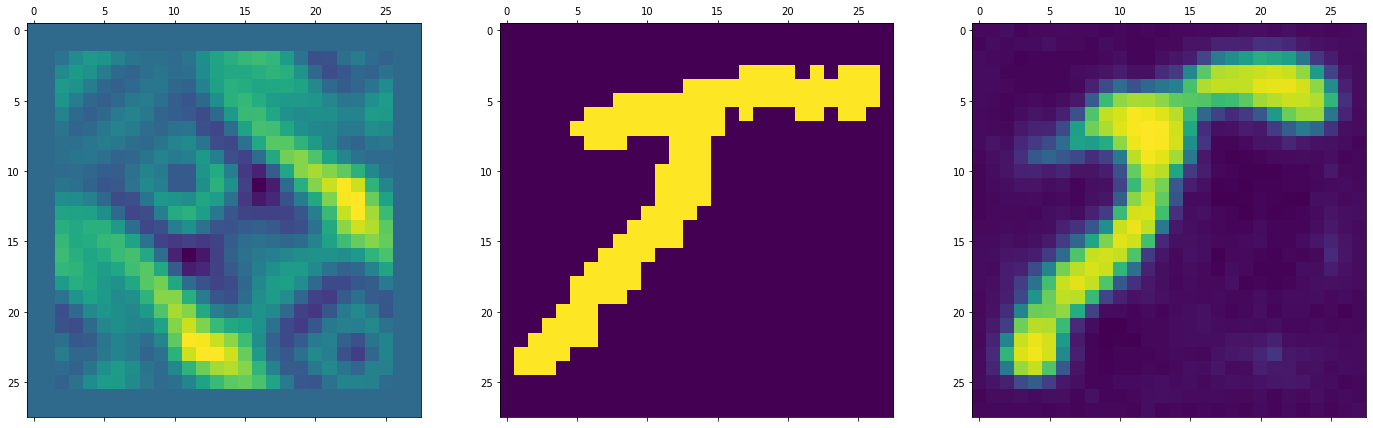

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_train_padded[30])
axs[1].matshow(targetMNIST_train[30])
axs[2].matshow(pred_train[30])

plt.show()

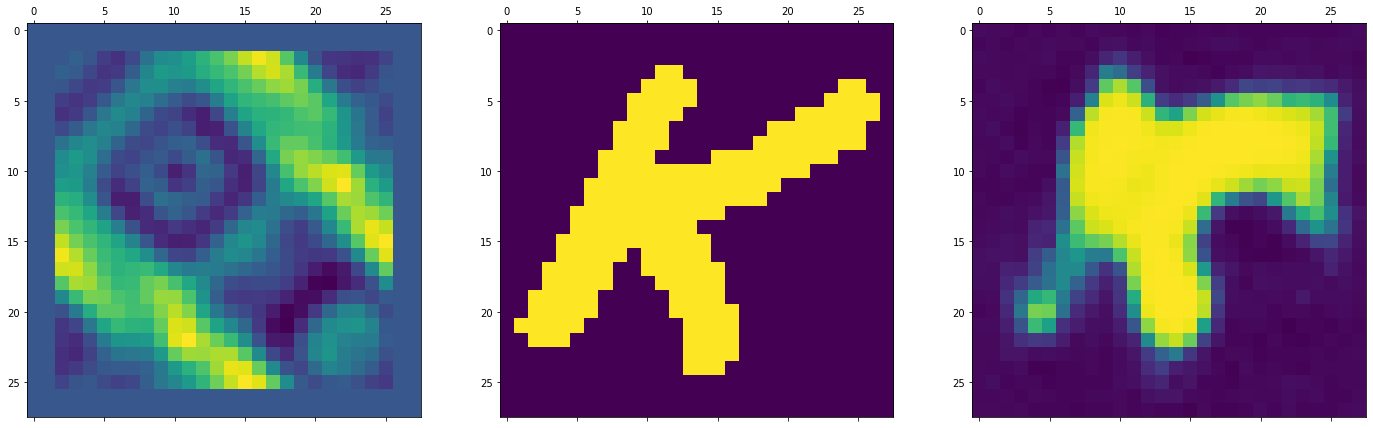

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test_padded[0])
axs[1].matshow(targetMNIST_test[0])
axs[2].matshow(pred_test[0])

plt.show()

In [31]:
best_model.evaluate(fieldMNIST_test_padded, targetMNIST_test)

5/5 [==============================] - 1s 69ms/step - loss: 0.2950 - accuracy: 0.8849


[0.29495006799697876, 0.8848528265953064]

In [20]:
best_model.evaluate(field_train_dif_perm, target_train_dif_perm)

16/16 [==============================] - 1s 57ms/step - loss: 0.3851 - accuracy: 0.5737


[0.38513436913490295, 0.5737037658691406]

UNET with Flatten Layer to output 28x28 image

In [52]:
def unet_with_flatten(input_shape):
    inputs = Input(input_shape)

    conv1 = Conv2D(28, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(28, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(56, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(56, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = Conv2D(128, 3, padding='same')(pool2)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)
    bottleneck = Conv2D(128, 3, padding='same')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    # Expansive Path
    up1 = Conv2DTranspose(56, (3, 3), strides=(2, 2), padding='same')(bottleneck)
    skip1 = Concatenate(axis=-1)([conv2, up1])
    conv3 = Conv2D(56, 3, padding='same')(skip1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(56, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    up2 = Conv2DTranspose(28, (3, 3), strides=(2, 2), padding='same')(conv3)
    skip2 = Concatenate(axis=-1)([conv1, up2])
    conv4 = Conv2D(28, 3, padding='same')(skip2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(28, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)

    flatten = Flatten()(conv4)

    dense = Dense(28*28*1, activation='relu')(flatten)

    reshape = Reshape((28, 28, 1))(dense)

    output = Conv2D(1, 1, activation='sigmoid')(reshape)

    # Cropping to the desired size (35, 35)
    # cropped_output = Cropping2D(((7, 6), (7, 6)))(output)

    model = Model(inputs=inputs, outputs=output)

    return model

In [53]:
kf1 = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
losses2 = []
val_losses2 = []
accuracy2 = []
val_accuracy2 = []
histories2 = []

acc_per_fold2 = []

   
Training for fold 1 ...
Epoch 1/80
45/45 [==============================] - 8s 137ms/step - loss: 0.4760 - accuracy: 0.6884 - val_loss: 0.5503 - val_accuracy: 0.6695 - lr: 2.0000e-04
Epoch 2/80
45/45 [==============================] - 7s 149ms/step - loss: 0.3959 - accuracy: 0.7882 - val_loss: 0.5411 - val_accuracy: 0.7053 - lr: 2.0000e-04
Epoch 3/80
45/45 [==============================] - 7s 146ms/step - loss: 0.3646 - accuracy: 0.8272 - val_loss: 0.6464 - val_accuracy: 0.7054 - lr: 2.0000e-04
Epoch 4/80
45/45 [==============================] - 6s 140ms/step - loss: 0.3444 - accuracy: 0.8435 - val_loss: 0.7508 - val_accuracy: 0.7053 - lr: 2.0000e-04
Epoch 5/80
45/45 [==============================] - 7s 157ms/step - loss: 0.3297 - accuracy: 0.8566 - val_loss: 0.8845 - val_accuracy: 0.7049 - lr: 2.0000e-04
Epoch 6/80
45/45 [==============================] - 6s 145ms/step - loss: 0.3180 - accuracy: 0.8667 - val_loss: 1.0034 - val_accuracy: 0.7045 - lr: 2.0000e-04
Epoch 7/80
45/45 [

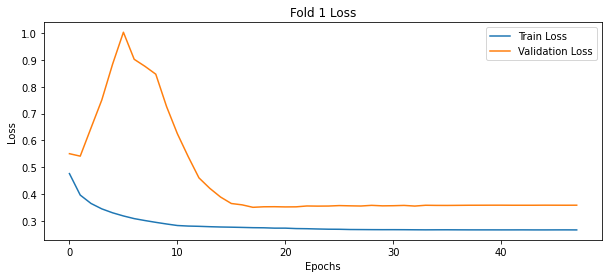

   
Training for fold 2 ...
Epoch 1/80
45/45 [==============================] - 13s 157ms/step - loss: 0.4808 - accuracy: 0.6821 - val_loss: 0.5646 - val_accuracy: 0.6946 - lr: 2.0000e-04
Epoch 2/80
45/45 [==============================] - 7s 151ms/step - loss: 0.4096 - accuracy: 0.7709 - val_loss: 0.5030 - val_accuracy: 0.7377 - lr: 2.0000e-04
Epoch 3/80
45/45 [==============================] - 7s 162ms/step - loss: 0.3835 - accuracy: 0.8008 - val_loss: 0.4956 - val_accuracy: 0.7379 - lr: 2.0000e-04
Epoch 4/80
45/45 [==============================] - 7s 152ms/step - loss: 0.3675 - accuracy: 0.8128 - val_loss: 0.5256 - val_accuracy: 0.7393 - lr: 2.0000e-04
Epoch 5/80
45/45 [==============================] - 7s 151ms/step - loss: 0.3548 - accuracy: 0.8233 - val_loss: 0.5717 - val_accuracy: 0.7388 - lr: 2.0000e-04
Epoch 6/80
45/45 [==============================] - 7s 146ms/step - loss: 0.3449 - accuracy: 0.8314 - val_loss: 0.5832 - val_accuracy: 0.7382 - lr: 2.0000e-04
Epoch 7/80
45/45 

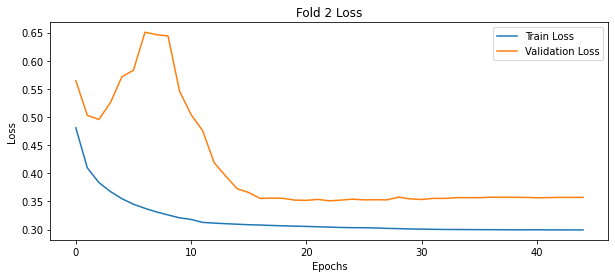

   
Training for fold 3 ...
Epoch 1/80
45/45 [==============================] - 9s 152ms/step - loss: 0.6889 - accuracy: 0.7144 - val_loss: 0.6914 - val_accuracy: 0.6899 - lr: 2.0000e-04
Epoch 2/80
45/45 [==============================] - 6s 138ms/step - loss: 0.6602 - accuracy: 0.7458 - val_loss: 0.6896 - val_accuracy: 0.6909 - lr: 2.0000e-04
Epoch 3/80
45/45 [==============================] - 6s 135ms/step - loss: 0.6464 - accuracy: 0.7579 - val_loss: 0.6880 - val_accuracy: 0.6903 - lr: 2.0000e-04
Epoch 4/80
45/45 [==============================] - 6s 143ms/step - loss: 0.6367 - accuracy: 0.7644 - val_loss: 0.6865 - val_accuracy: 0.6895 - lr: 2.0000e-04
Epoch 5/80
45/45 [==============================] - 6s 136ms/step - loss: 0.6294 - accuracy: 0.7689 - val_loss: 0.6849 - val_accuracy: 0.6888 - lr: 2.0000e-04
Epoch 6/80
45/45 [==============================] - 6s 141ms/step - loss: 0.6241 - accuracy: 0.7720 - val_loss: 0.6831 - val_accuracy: 0.6904 - lr: 2.0000e-04
Epoch 7/80
45/45 [

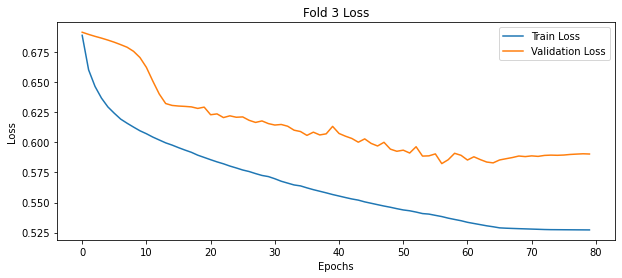

   
Training for fold 4 ...
Epoch 1/80
45/45 [==============================] - 8s 153ms/step - loss: 0.4526 - accuracy: 0.7316 - val_loss: 0.5275 - val_accuracy: 0.7180 - lr: 2.0000e-04
Epoch 2/80
45/45 [==============================] - 6s 133ms/step - loss: 0.3723 - accuracy: 0.8127 - val_loss: 0.5584 - val_accuracy: 0.7188 - lr: 2.0000e-04
Epoch 3/80
45/45 [==============================] - 6s 133ms/step - loss: 0.3469 - accuracy: 0.8335 - val_loss: 0.6651 - val_accuracy: 0.7181 - lr: 2.0000e-04
Epoch 4/80
45/45 [==============================] - 6s 130ms/step - loss: 0.3311 - accuracy: 0.8478 - val_loss: 0.8109 - val_accuracy: 0.7202 - lr: 2.0000e-04
Epoch 5/80
45/45 [==============================] - 6s 130ms/step - loss: 0.3205 - accuracy: 0.8571 - val_loss: 0.9564 - val_accuracy: 0.7195 - lr: 2.0000e-04
Epoch 6/80
45/45 [==============================] - 6s 128ms/step - loss: 0.3139 - accuracy: 0.8636 - val_loss: 1.0673 - val_accuracy: 0.7197 - lr: 2.0000e-04
Epoch 7/80
45/45 [

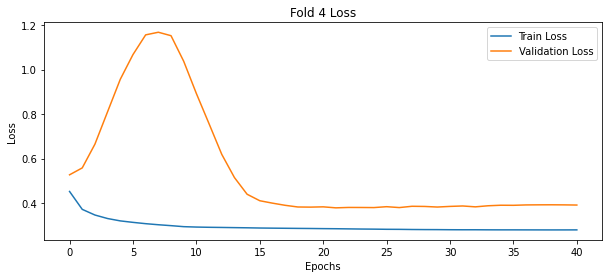

   
Training for fold 5 ...
Epoch 1/80
45/45 [==============================] - 8s 153ms/step - loss: 0.4671 - accuracy: 0.7198 - val_loss: 0.5067 - val_accuracy: 0.7093 - lr: 2.0000e-04
Epoch 2/80
45/45 [==============================] - 6s 137ms/step - loss: 0.3964 - accuracy: 0.7710 - val_loss: 0.5380 - val_accuracy: 0.7103 - lr: 2.0000e-04
Epoch 3/80
45/45 [==============================] - 6s 134ms/step - loss: 0.3760 - accuracy: 0.7873 - val_loss: 0.6266 - val_accuracy: 0.7103 - lr: 2.0000e-04
Epoch 4/80
45/45 [==============================] - 6s 139ms/step - loss: 0.3668 - accuracy: 0.7950 - val_loss: 0.7425 - val_accuracy: 0.7116 - lr: 2.0000e-04
Epoch 5/80
45/45 [==============================] - 6s 137ms/step - loss: 0.3610 - accuracy: 0.8002 - val_loss: 0.8656 - val_accuracy: 0.7118 - lr: 2.0000e-04
Epoch 6/80
45/45 [==============================] - 6s 137ms/step - loss: 0.3556 - accuracy: 0.8050 - val_loss: 0.9501 - val_accuracy: 0.7122 - lr: 2.0000e-04
Epoch 7/80
45/45 [

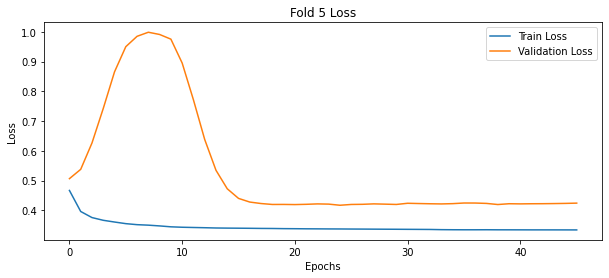

In [54]:
for train_index, val_index in kf1.split(fieldMNIST_train_full):
    print('   ')
    print(f'Training for fold {fold_no} ...')

    X_train, X_val = fieldMNIST_train_full[train_index], fieldMNIST_train_full[val_index]
    y_train, y_val = targetMNIST_train_full[train_index], targetMNIST_train_full[val_index]


    model2 = unet_with_flatten(input_shape=X_train.shape[1:])

    model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics='accuracy')
    early_stopping = EarlyStopping(monitor='loss', patience=10,min_delta=0.001)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=8, min_delta=0.0001, min_lr=1e-9)
    # checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        
    history = model2.fit(X_train, y_train, 
                        validation_data=(X_val, y_val),
                        epochs=80, 
                        batch_size=10,
                        callbacks=[early_stopping,reduce_lr])
    histories2.append(history.history)

        #Save model trained on each fold.
    model2.save('models_flatten/model_fold_'+str(fold_no)+'.h5')   

    # Evaluate the model - repor accuracy and capture it into a list for future reporting
    scores2 = model2.evaluate(fieldMNIST_test, targetMNIST_test, verbose=0)
    acc_per_fold2.append(scores2[1] * 100)

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

    losses2.append((history.history['loss']))
    val_losses2.append((history.history['val_loss']))
    accuracy2.append((history.history['accuracy']))
    val_accuracy2.append((history.history['val_accuracy']))

    fold_no += 1

In [56]:
acc_per_fold2

[84.01822447776794,
 81.52821063995361,
 75.48247575759888,
 82.72977471351624,
 78.59823107719421]

In [58]:
best_model_flatten = load_model('models_flatten/model_fold_1.h5')
pred_test_flatten = best_model_flatten.predict(fieldMNIST_test)
pred_train_flatten = best_model_flatten.predict(fieldMNIST_train_full)
pred_dif_perm_flatten = best_model_flatten.predict(field_dif_perm_transformed)

20/20 [==============================] - 1s 45ms/step


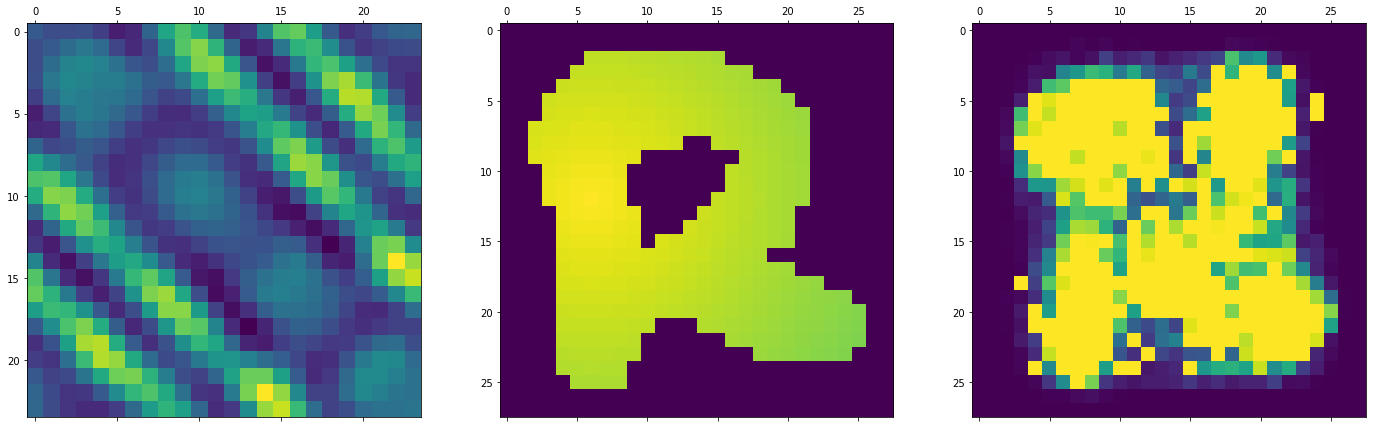

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(field_dif_perm_transformed[0])
axs[1].matshow(target_dif_perm_transformed[0])
axs[2].matshow(pred_dif_perm_flatten[0])

plt.show()

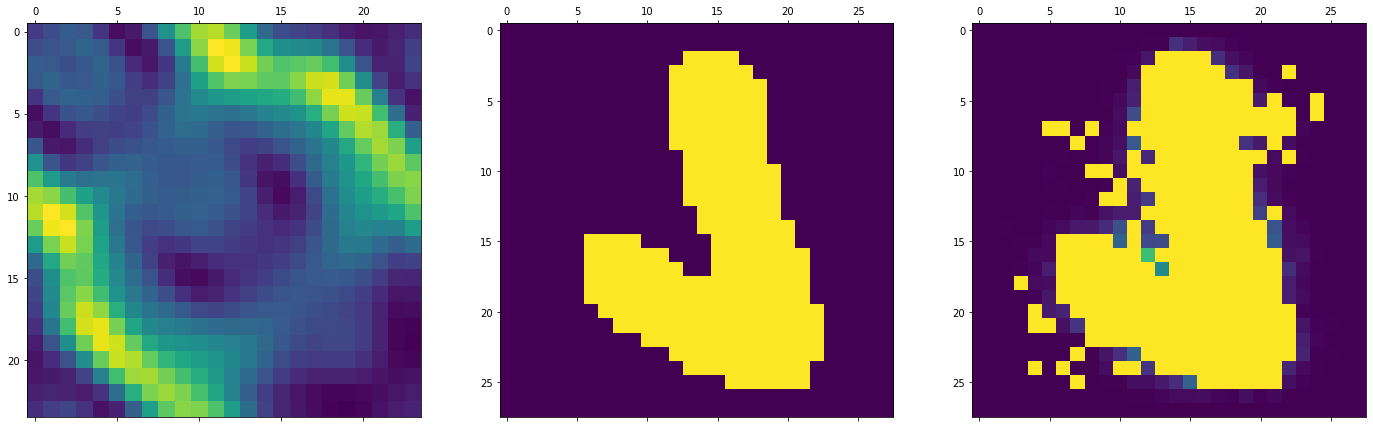

In [73]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_train_full[20])
axs[1].matshow(targetMNIST_train_full[20])
axs[2].matshow(pred_train_flatten[20])

plt.show()

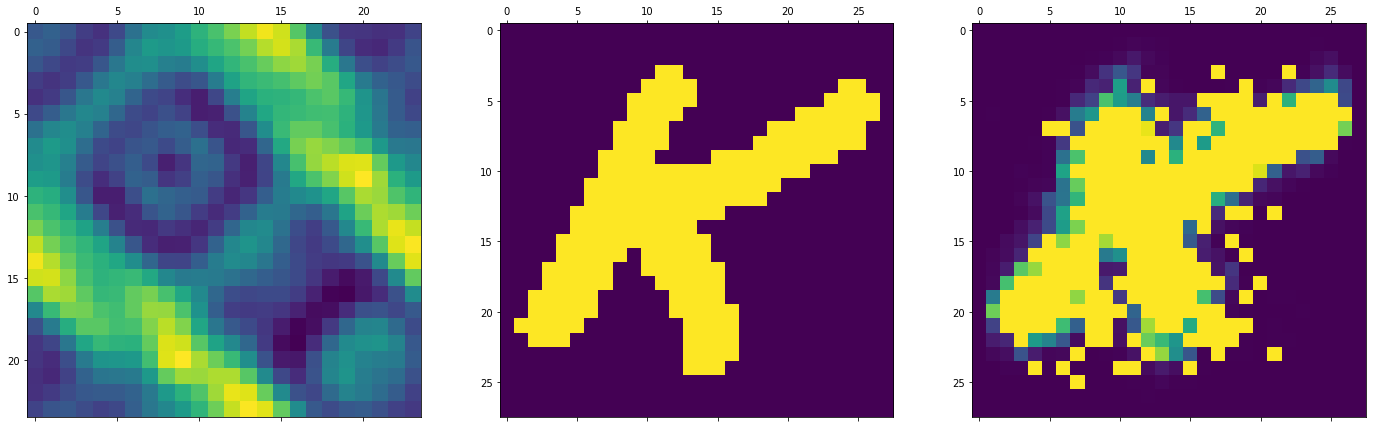

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(24, 24))

axs[0].matshow(fieldMNIST_test[0])
axs[1].matshow(targetMNIST_test[0])
axs[2].matshow(pred_test_flatten[0])

plt.show()

In [61]:
best_model_flatten.evaluate(fieldMNIST_test, targetMNIST_test)

5/5 [==============================] - 1s 44ms/step - loss: 0.3604 - accuracy: 0.8402


[0.360355943441391, 0.8401822447776794]

In [ ]:
best_model.evaluate(field_train_dif_perm, target_train_dif_perm)

16/16 [==============================] - 1s 57ms/step - loss: 0.3851 - accuracy: 0.5737


[0.38513436913490295, 0.5737037658691406]